## UNet for Depth Estimation on GeoPose3k


Please note, this section cannot be run since a lot of pre-processing involving the labels for GeoPose3k was done. A rough implementation is present in the helper folder fro all preprocessing code. For further information, please contact on cjblackout@gmail.com

#### Imports

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import layers

DATA_PATH = "C:\\Users\\cjbla\\OneDrive\\Desktop\\Code\\data\\images_depth\\depth_dataset.csv"

#### Dataset Creation

In [2]:
def load_npy_file(label_path):
    label = np.load(label_path)
    label = cv2.resize(label, dsize=(256, 256), interpolation=cv2.INTER_NEAREST)
    return tf.convert_to_tensor(label, dtype=tf.float32)

@tf.function
def load_image(image_path, label_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256], method='nearest')
    image = tf.image.convert_image_dtype(image, tf.float32)

    label = tf.numpy_function(load_npy_file, [label_path], tf.float32)

    return image, label

def load_dataset(csv_file):
    dataset = tf.data.experimental.CsvDataset(
        csv_file,
        [tf.string, tf.string],
        header=True,
        field_delim=','
    )
    dataset = dataset.map(load_image)
    return dataset

dataset = load_dataset(DATA_PATH)

In [3]:
dataset.prefetch(tf.data.experimental.AUTOTUNE)
dataset.cache('cache/dataset.cache')

<CacheDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>

#### Sanity Check

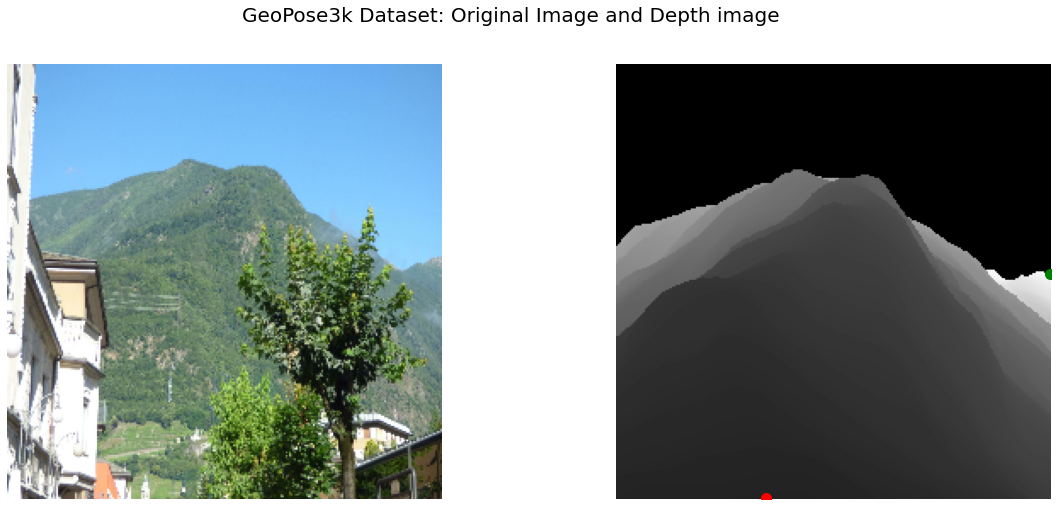

In [7]:
fig, ax = plt.subplots(figsize=(20, 8))

for image, label in dataset.take(1):
    # Plot the original image
    ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(image)
    ax1.axis('off')

    # Get the position of the largest and smallest values
    max_position = np.where(label == np.amax(label))
    min_position = np.where(label == np.amin(label[label > 100]))

    # Plot the depth image with a red dot on the position of the smallest value and a green dot on the position of the largest value
    ax2 = plt.subplot(1, 2, 2)
    ax2.imshow(label, cmap='gray')
    ax2.plot(max_position[1], max_position[0], 'go', markersize=10)
    ax2.plot(min_position[1], min_position[0], 'ro', markersize=10)
    ax2.axis('off')

plt.suptitle("GeoPose3k Dataset: Original Image and Depth image", fontsize=20)
plt.show()

#### Model Definition

In [5]:
def unet_model(input_shape=(256, 256, 3)):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    # Down-sampling through the model
    skips = []
    for filters in [64, 128, 256]:
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("selu")(x)

        skips.append(x)
        x = layers.MaxPooling2D(2)(x)

    # Bottleneck
    x = layers.Conv2D(512, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Up-sampling through the model
    for filters, skip in reversed(list(zip([256, 128, 64], skips))):
        x = layers.UpSampling2D(2)(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("selu")(x)

    # Final layer
    outputs = layers.Conv2D(1, 1)(x)
    outputs = layers.Activation('selu')(outputs)

    return keras.Model(inputs=inputs, outputs=outputs)

#### Dataset Split

In [13]:
#add extra dimension to the dataset
train_dataset = dataset.take(2500).map(lambda x,y: (tf.expand_dims(x,axis=0), tf.expand_dims(y,axis=0)))
val_dataset = dataset.skip(2500).take(100).map(lambda x,y: (tf.expand_dims(x,axis=0), tf.expand_dims(y,axis=0)))
test_dataset = dataset.skip(2600).take(500).map(lambda x,y: (tf.expand_dims(x,axis=0), tf.expand_dims(y,axis=0)))

#### Model Compilation

In [7]:
# Create a UNET model
model = unet_model()

# Compile the model with loss and optimizer
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=tf.keras.metrics.MeanAbsoluteError())   #Check if mean or last shown value

# Define a callback to save the model after each epoch
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    "models/depth_model_5.h5", save_freq="epoch"
)

#### Execute

In [8]:
# Train the model on the dataset
model.fit(train_dataset, epochs=5, callbacks=[checkpoint_callback], validation_data=val_dataset, use_multiprocessing=True, workers=4, shuffle=True) 

Epoch 1/5
2500/2500 [==============================] - 254s 97ms/step - loss: -33948.2969 - mean_absolute_error: 2301.6963 - val_loss: -30399.1172 - val_mean_absolute_error: 1994.3738
Epoch 2/5
2500/2500 [==============================] - 241s 97ms/step - loss: -35092.5625 - mean_absolute_error: 2302.2158 - val_loss: -30399.1230 - val_mean_absolute_error: 1993.4536
Epoch 3/5
2500/2500 [==============================] - 242s 97ms/step - loss: -35092.6367 - mean_absolute_error: 2301.5142 - val_loss: -30399.1230 - val_mean_absolute_error: 1993.4457
Epoch 4/5
2500/2500 [==============================] - 240s 96ms/step - loss: -35092.6367 - mean_absolute_error: 2301.5142 - val_loss: -30399.1230 - val_mean_absolute_error: 1993.4436
Epoch 5/5
2500/2500 [==============================] - 240s 96ms/step - loss: -35092.6367 - mean_absolute_error: 2301.5120 - val_loss: -30399.1230 - val_mean_absolute_error: 1993.4430


#### Evalute

In [9]:
#perform inference on the test dataset
model.evaluate(test_dataset, use_multiprocessing=True, workers=4)

500/500 [==============================] - 138s 53ms/step - loss: -29717.1309 - mean_absolute_error: 1948.8130


[-29717.130859375, 1948.81298828125]

#### Dislpay the Depth Map

1/1 [==============================] - 0s 206ms/step


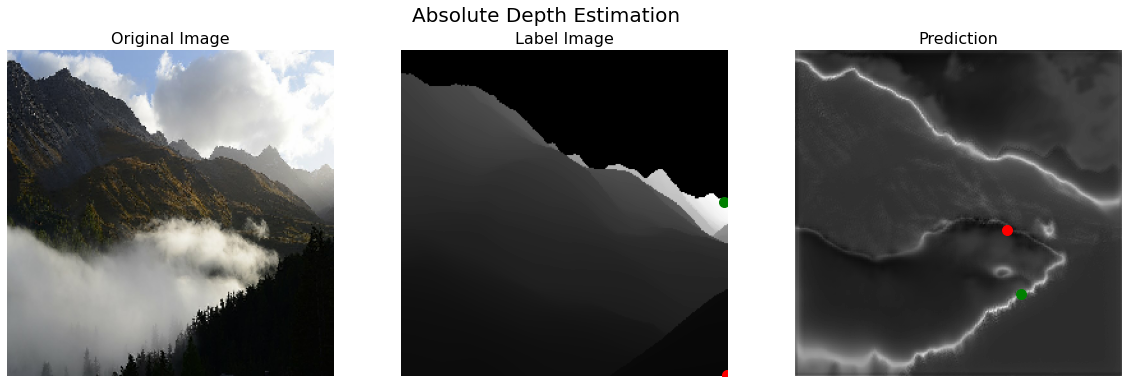

In [17]:
import matplotlib.pyplot as plt

# Import the model models/depth_model_5.h5
model = tf.keras.models.load_model('models/depth_model_5.h5')

for image, label in test_dataset.take(1):
    # Create a figure with 1 row and 3 columns
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    # Plot the original image
    axs[0].imshow(image[0])
    axs[0].set_title('Original Image', fontsize=16)
    axs[0].axis('off')  # Remove the x and y axis

    # Plot the label image with a red dot on the position of the smallest value and a green dot on the position of the largest value
    max_position = np.where(label[0] == np.amax(label[0]))
    min_position = np.where(label[0] == np.amin(label[0][label[0] > 100]))
    axs[1].imshow(label[0], cmap='gray')
    axs[1].plot(max_position[1], max_position[0], 'go', markersize=10)
    axs[1].plot(min_position[1], min_position[0], 'ro', markersize=10)
    axs[1].set_title('Label Image', fontsize=16)
    axs[1].axis('off')  # Remove the x and y axis

    # Perform inference with the model and plot the prediction with a red dot on the position of the smallest value and a green dot on the position of the largest value
    prediction = model.predict(image)[0]
    max_position = np.where(prediction == np.amax(prediction))
    min_position = np.where(prediction == np.amin(prediction[prediction > 0]))
    axs[2].imshow(prediction, cmap='gray')
    axs[2].plot(max_position[1], max_position[0], 'go', markersize=10)
    axs[2].plot(min_position[1], min_position[0], 'ro', markersize=10)
    axs[2].set_title('Prediction', fontsize=16)
    axs[2].axis('off')  # Remove the x and y axis

    # Add a title to the figure
    fig.suptitle('Absolute Depth Estimation', fontsize=20)

    # Show the plot
    plt.show()

## Using DPT pretrained model with Baseline Sky Detection

#### Imports

In [1]:
import torch
import numpy as np
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import keras

from ipyfilechooser import FileChooser
from transformers import DPTImageProcessor, DPTForDepthEstimation
from PIL import Image
from baseline import baseline_mean_shift_third
from constants import DATASET_FOLDER

#### Choose the image

In [2]:
fc = FileChooser(DATASET_FOLDER)
display(fc)

FileChooser(path='C:\Users\cjbla\OneDrive\Desktop\Code\data\dataset', filename='', title='', show_hidden=False…

#### Run DPT on the selected image

In [3]:
image = Image.open(fc.selected)

processor = DPTImageProcessor.from_pretrained("Intel/dpt-large")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")

# prepare image for the model
inputs = processor(images=image, return_tensors="pt")

#start time
start = time.time()
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth
#end time
end = time.time()

print(end - start)

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


3.7342803478240967


#### Convert Images and Depth map to approriate format

In [4]:
#invert the values of depth
depth_inverted = np.invert(depth)

#convert depth_inverted to PIL Image object
depth_inverted = Image.fromarray(depth_inverted)

# assuming `image` is a PIL Image object, convert it to a numpy array
image = np.array(image)

#### Get Sky Segemenation Mask from Baseline

In [5]:
# apply mean shift algorithm
sky_mask_baseline, _, _ = baseline_mean_shift_third(image)

Get Sky Segmentation Mask from Model

In [6]:
model = keras.models.load_model("models/model_30000_5_optimized.h5")

sns.set_style("white")
sns.set_context("paper", font_scale=1)

image_model = tf.io.read_file(fc.selected)
image_model = tf.image.decode_jpeg(image_model, channels=3)

#get the shape of the image
original_shape = image_model.shape

image_model = tf.image.resize(image_model, [256, 256], method='nearest')
image_model = tf.image.convert_image_dtype(image_model, tf.float32)
image_model = tf.expand_dims(image_model, axis=0)

#reshape the prediction to the original shape
prediction = model.predict(image_model)
prediction = tf.image.resize(prediction, [original_shape[0], original_shape[1]], method='nearest')

#make a mask from the prediction where the value of the element is greater than 0.5 is 1 and 0 otherwise
sky_mask_model = np.where(prediction[0] > 0.5, 1, 0)
sky_mask_model = sky_mask_model.reshape(original_shape[0], original_shape[1])

1/1 [==============================] - 4s 4s/step


#### Mask the Depth Image using both masks

In [7]:
#assuming `mask` and `depth_inverted` are defined, use mask on the depth image
depth_masked_model = np.ma.masked_array(depth_inverted, mask=sky_mask_model)

#assuming `mask` and `depth_inverted` are defined, use mask on the depth image
depth_masked_baseline = np.ma.masked_array(depth_inverted, mask=sky_mask_baseline)

#### Display All Images

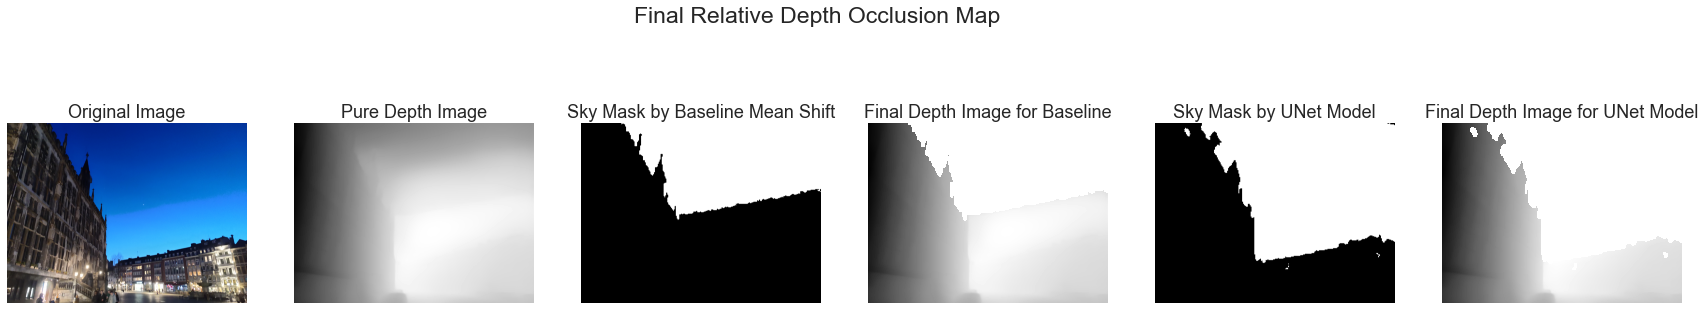

: 

In [19]:
# Create a figure with 1 row and 4 columns
fig, axs = plt.subplots(1, 6, figsize=(30, 6))

# Plot the original image
axs[0].imshow(image)
axs[0].set_title('Original Image', fontsize=18)
axs[0].axis('off')

# Plot the depth-inverted image
axs[1].imshow(depth_inverted, cmap='gray')
axs[1].set_title('Pure Depth Image', fontsize=18)
axs[1].axis('off')

# Plot the sky mask
axs[2].imshow(sky_mask_baseline, cmap='gray')
axs[2].set_title('Sky Mask by Baseline Mean Shift', fontsize=18)
axs[2].axis('off')

# Plot the depth-masked image
axs[3].imshow(depth_masked_baseline, cmap='gray')
axs[3].set_title('Final Depth Image for Baseline', fontsize=18)
axs[3].axis('off')

# Plot the sky mask
axs[4].imshow(sky_mask_model, cmap='gray')
axs[4].set_title('Sky Mask by UNet Model', fontsize=18)
axs[4].axis('off')

# Plot the depth-masked image
axs[5].imshow(depth_masked_model, cmap='gray')
axs[5].set_title('Final Depth Image for UNet Model', fontsize=18)
axs[5].axis('off')

# Add a title to the figure
fig.suptitle('Final Relative Depth Occlusion Map', fontsize=23)

# Show the plot
plt.show()